# Nonparametric Differential Equations (npde)

This document describes how to use the software implementation of our **npsde** (nonparametric stochastic differential equations) model. The implementation is in python3.5 and requires __[TensorFlow(1.6.0+)](https://www.tensorflow.org/)__ and __[GPflow(1.1+)](https://github.com/GPflow/GPflow)__. To learn more about the model, __[here](https://arxiv.org/abs/1807.05748)__ is a link to the our paper to be presented in MLSP in September 2018. This repository also overrides the MATLAB implementation of **npODE** model for learning ordinary differential equations (__[here](http://proceedings.mlr.press/v80/heinonen18a/heinonen18a.pdf)__ is the npODE ICML 2018 paper and __[here](https://github.com/cagatayyildiz/npode)__ is the old MATLAB implementation).

&nbsp;

**Notebook Sections**

The notebook consists of three sections, each containing an example fit where the underlying dynamics are governed by an ODE, SDE with constant diffusion, and SDE with state dependent diffusion. Van der Pol (VDP) oscillator, whose dynamics are given by equations below, is used as the running example:
\begin{align*}
\frac{dx_1}{dt} = x_2 \qquad \qquad \frac{dx_2}{dt} &= (1-x_1^2) x_2 - x_1 
\end{align*}
In examples below, true constant diffusion is equal to 0.2 and the state dependent diffusion function is given by $g(x)=3\mathcal{N}(x;[-2,0],0.5I)$. The model is completely unaware of the dynamics, and infers the dynamics by placing Gaussian process priors over the drift and diffusion functions and computing the posterior.

&nbsp;

**Main Functions**

There are three main python functions that provide an easy-to-use interface to the model implementation:
 * ```npde_fit``` -  fits the model (ODE/SDE) to the input data and observed time points  
 * `predict` - a class function that predicts signals given a `npde` model that stores the learned SDE dynamics, an initial value and observed time points   
 * `sample` - a class function that draws samples from a learned SDE system signals given the same input in `predict` function

&nbsp;

**For Better Performance**

The quality of the fit relies on many factors including the width of the inducing point grid `W`, lengthscales `ell`, learning rate `eta`, number of optimization steps `num_iter` and number of samples `Nw` used for optimization in SDEs. Few notes about enhancing the performance: 
 * In general, a denser inducing point grid and more samples for SDEs are better - the higher `W` and `Nw`, the better. 
 * Learning rate must always be carefully tuned for every problem and even data set.
 * Higher lengthscale values result in smoother trajectories. Although optimized, we reserve it for model selection. For example in modeling constant diffusions, lengthscale of the diffusion function must be high, e.g., $10^5$. It is also a good idea to perform the optimization several times over a grid of lengthscales. For instance, a good grid in case of VDP oscillator with `W=5` would be `linspace(0.75,4,10`).
 * It should also be noted that `W` and `ell` should be tuned together carefully. In general, if one is increased, then the other should be decreased.

## Preparing the Environment

In [1]:
%load_ext autoreload
%autoreload 2

# avoid GPU due to Cholesky decompositions
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
sess = tf.InteractiveSession()

import numpy as np
from utils import gen_data, plot_model
from npde_helper import build_model, fit_model, save_model, load_model

## 1. ODE

### Data Generation

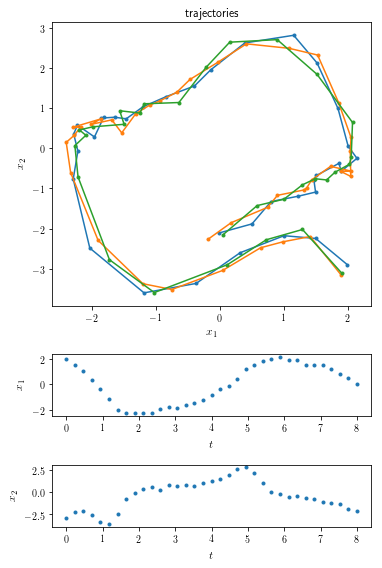

In [10]:
np.random.seed(918273) # just for illustration purposes
x0,t,Y,X,D,f,g = gen_data('vdp', Ny=[35,40,30], tend=8, nstd=0.1)

###  Inference

Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
       iteration       objective
               1         249.645
              50         132.819
             100          97.958
             150          71.826
             200          53.669
             250          41.135
             300          37.499
             350          40.130
             400          28.935
             450          47.454
             500          32.414
Optimization ends.
Plotting...
noise variance:        [0.00939917 0.02234478]
signal variance:       1.5292439453611237
lengthscales:          [0.8330111  1.23143427]


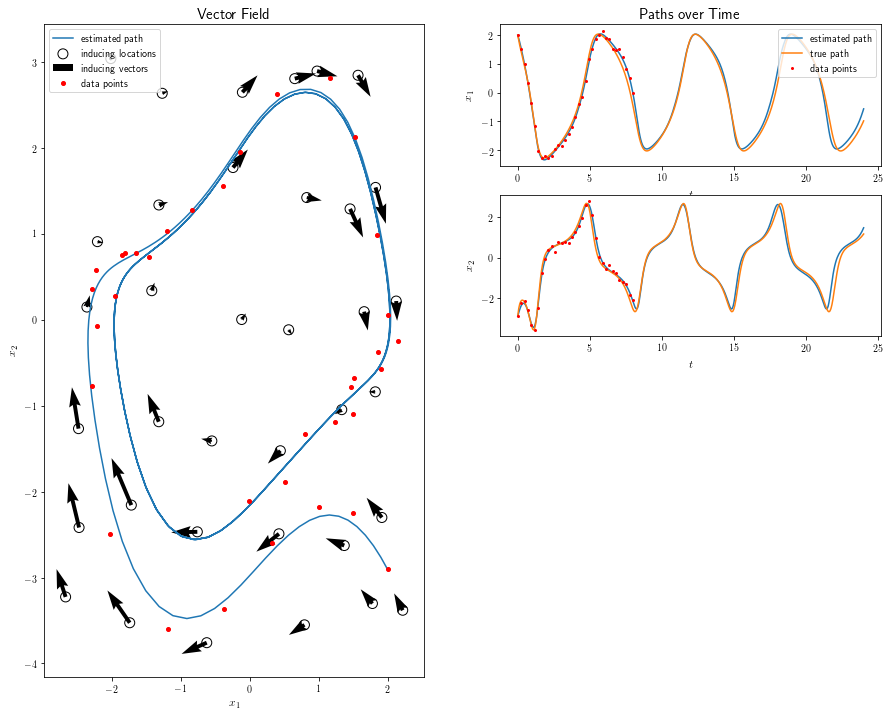

In [11]:
# t - observation times, a python array of numpy vectors
# Y - observations, a python array of numpy matrices, data points are in rows
# step size (eta) must be carefully tuned for different data sets
npde = build_model(sess, t, Y, model='ode', sf0=1.0, ell0=np.ones(2), W=6, ktype="id")
npde = fit_model(sess, npde, t, Y, num_iter=500, print_every=50, eta=0.02, plot_=True)

# how to plot the model
# plot_model(npde,t,Y)

# how to save/load the model
# save_model(npde,'npde.pkl')
# npde = load_model('npde.pkl',sess)

## 2. SDE with Constant Diffusion

### Data Generation

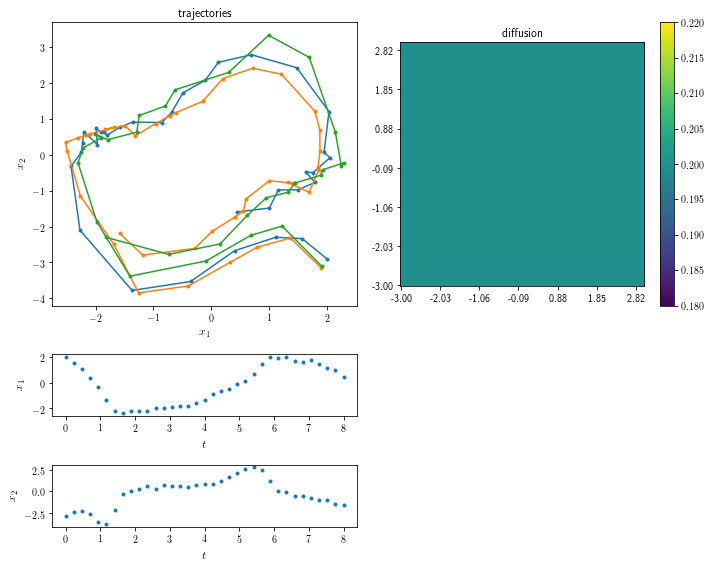

In [7]:
np.random.seed(918273)
x0,t,Y,X,D,f,g = gen_data('vdp-cdiff', Ny=[35,40,30], tend=8, nstd=0.1)

### Inference

Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
       iteration       objective
               1         368.228
              50         257.265
             100         200.507
             150         185.338
             200         162.259
             250         171.621
             300         168.109
             350         189.884
             400         174.760
             450         156.297
             500         146.358
             550         138.856
             600         148.299
             650         151.654
             700         140.672
             750         135.049
             800         145.141
             850         146.321
             900         226.464
             950         151.841
            1000         145.006
Optimization ends.
Plotting...
noise variance:        [0.01321557 0.02131561]
signal variance:       1.8262625672267778
lengthscales:          [0.78597971 1.0454974

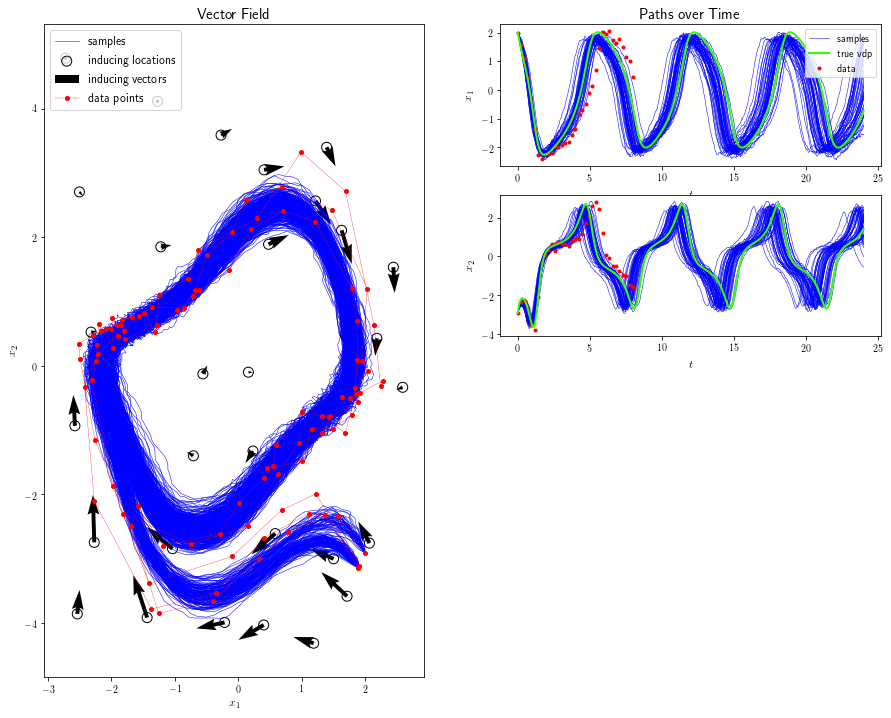

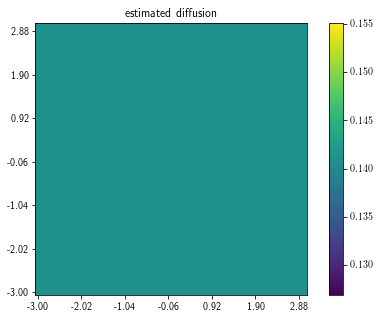

In [9]:
# in order to constant diffusion, lengthscale of the diffusion process (ellg0) must be initialized to a big number
npde = build_model(sess, t, Y, model='sde', sf0=1.0, ell0=np.ones(2), W=6, ellg0=[1e5], ktype="id")
npde = fit_model(sess, npde, t, Y, Nw=100, num_iter=1000, print_every=50, eta=0.02, plot_=True)

### Predictions

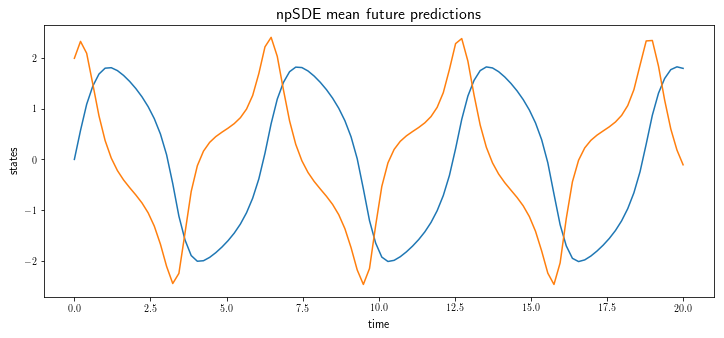

In [6]:
x0 = [0,2] # initial value
t = np.linspace(0,20,100) # time points 
path = npde.predict(x0,t)
path = sess.run(path)

plt.figure(figsize=(12,5))
plt.plot(t,path)
plt.xlabel('time',fontsize=12)
plt.ylabel('states',fontsize=12)
plt.title('npSDE mean future predictions',fontsize=16);

### Sampling

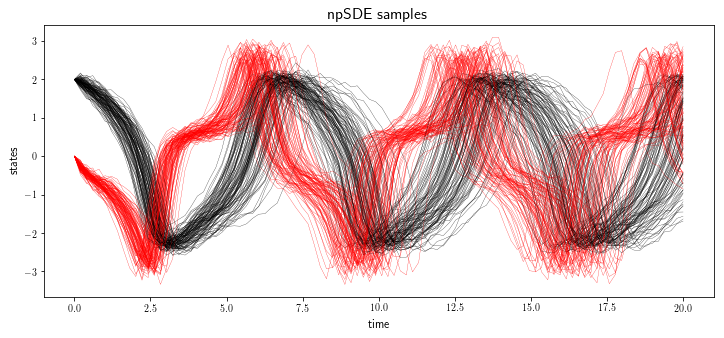

In [7]:
x0 = [2,0]
t = np.linspace(0,20,100)
Nw = 100 # number of samples
samples = npde.sample(x0,t,Nw=100)
samples = sess.run(samples)

plt.figure(figsize=(12,5))
for i in range(Nw):
    plt.plot(t,samples[i,:,0],'-k',linewidth=0.25)
    plt.plot(t,samples[i,:,1],'-r',linewidth=0.25)
plt.xlabel('time',fontsize=12)
plt.ylabel('states',fontsize=12)
plt.title('npSDE samples',fontsize=16);
plt.savefig('samples.png', dpi=200)

## 3. SDE with State Dependent Diffusion

### Data Generation

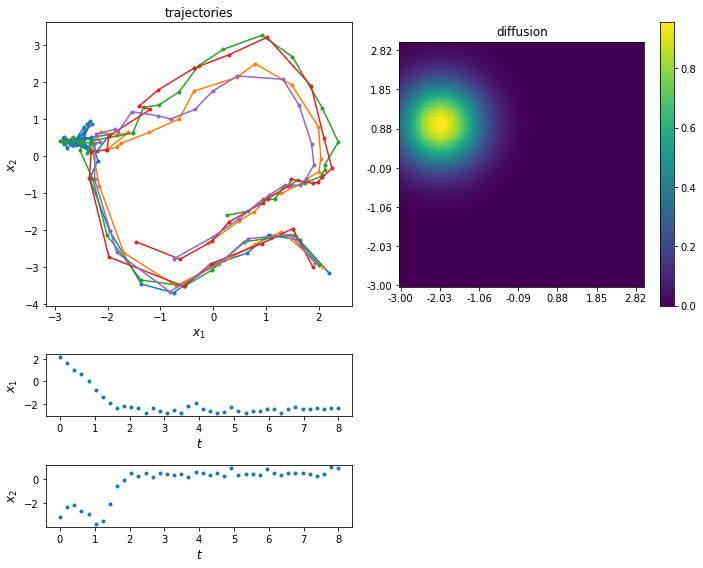

In [3]:
np.random.seed(918273)
x0,t,Y,X,D,f,g = gen_data('vdp-sdiff', Ny=[40,30,40,30,30], tend=8, nstd=0.1)

### Inference

Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
       iteration       objective
               1        1012.824
              50         548.068
             100         526.857
             150         452.713
             200         409.992
             250         379.502
             300         354.766
             350         351.779
             400         359.043
             450         424.229
             500         396.595
             550         337.357
             600         310.569
             650         318.210
             700         308.164
             750         316.491
             800         334.696
             850         315.660
             900         295.563
             950         326.199
            1000         340.205
Optimization ends.
Plotting...
noise variance:        [0.0363843  0.03091731]
signal variance:       1.4967658549562317
lengthscales:          [0.90106904 1.0449276

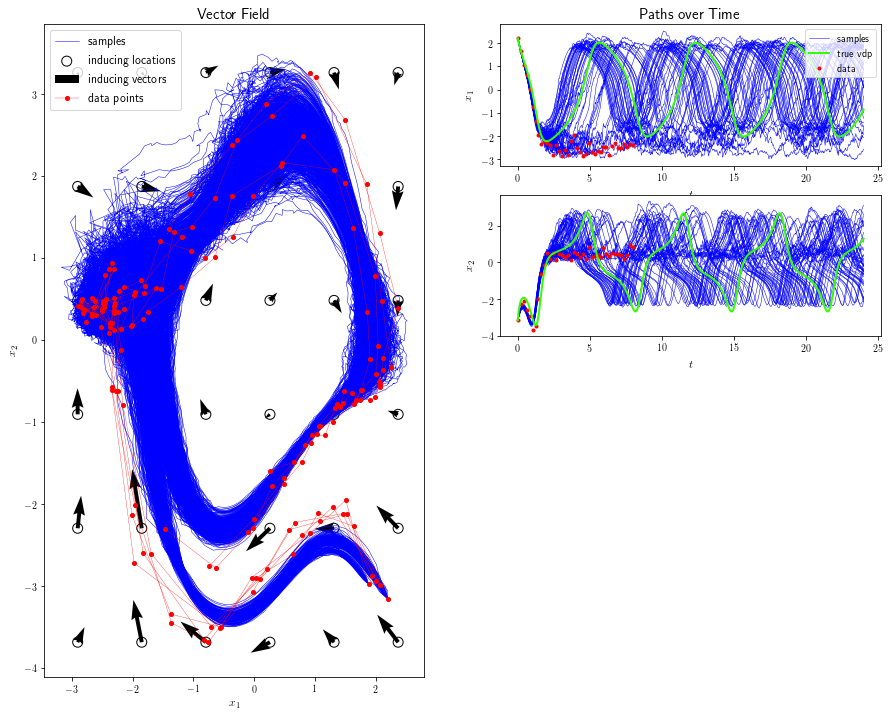

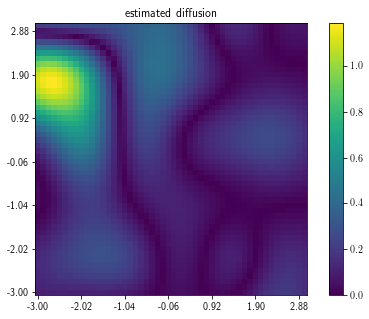

In [6]:
npde = build_model(sess, t, Y, model='sde', sf0=1.0, ell0=np.ones(2), W=6, ellg0=[1.0], ktype="id", fix_Z=True)
npde = fit_model(sess, npde, t, Y, Nw=50, num_iter=1000, print_every=50, eta=0.01, plot_=True)